In [1]:
from PIL import Image
import glob 
import os

from IPython.display import display
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.patches import Circle, Ellipse

from plotlib.base_line import base_line
from plotlib.base_scatter import base_scatter

In [2]:
def load_dataframes(path, acc_column, sort_col_name, ascending=True):
    """
    
    Parameters
    ----------
    
    path: string,
        path to the dataframes.
    acc_column: int,
        column containing the test accuracy of the classifier.
    sort_col_name: string:
        name of the column along which to sort the dataframe entries. (Usually is the 'RP' number.)
    ascending: boolean,
        If True, sort the dataframe in ascending order. Defaults to True.
    Returns
    -------
    
    dataframes: list of DataFrames,
        list of pandas DataFrames.
    final_data: list,
        contains the data on the run with the highest accuracy.
    """
    
    allFiles = glob.glob(path + "/*.csv")
    dataframes = []
    
    for file in allFiles:
        df = pd.read_csv(file, sep='\t')
        dataframes.append(df)
    
    final_data = []

    for dataframe in dataframes:
        
        best_run_idx = dataframe[acc_column].idxmax()
        best_run = pd.DataFrame([dataframe.iloc[best_run_idx]])
        final_data.append(best_run.values)

    final_data = np.concatenate(final_data)
    best_runs = pd.DataFrame(final_data, columns=list(dataframes[0].columns.values)).sort_values(by=[sort_col_name], 
                                                                                                 ascending=ascending)
    
    return best_runs.reset_index(drop=True), dataframes, final_data

In [3]:
def normalize(df, full_model_size, bp=False):
    if bp is True:
        normalized = df["model size-tot"]/full_model_size *100
    else:
        normalized =   (df["model size [MB]"] + df["ridge size [MB]"])/full_model_size *100
    return normalized 

In [4]:
def set_title(dataset_name, model_name=None):
    
    if model_name is None:
        return "{}".format(dataset_name[0].upper() + dataset_name[1:].replace("_", " "))
        
    if model_name[:3] == "vgg":
        model_name = model_name.upper()
    
    elif model_name[:3] == "res":
        model_name = model_name[0].upper() + model_name[1:3] + model_name[3].upper() + model_name[4:]
    
    elif model_name[:3] == "den":
        model_name = model_name[0].upper() + model_name[1:5] + model_name[5].upper() + model_name[6:]
    
    return "{} - {}".format(dataset_name[0].upper() + dataset_name[1:].replace("_", " "), model_name)

In [5]:
model_name, model_options = 'densenet169', 'full'
OPU = "Saturn"
dataset = "animals10"

new_path = os.path.join("/home/luca/Desktop/TL/Blogpost/TL_blogpost/data/naive", dataset)

image_path = '/home/luca/Desktop/TL/Blogpost/images/'

img_format='pdf'

In [6]:
n_components = 2
dtype = "float16"

path_S = os.path.join(new_path, "{}_{}_brutal".format(model_name, OPU))
train, inference = {}, {}

for dtype in ("float16", "float32"):
    OPU_path = os.path.join(path_S, "OPU_{}_{}_{}".format(n_components, model_options, dtype))
    train_df, _, _ = load_dataframes(os.path.join(OPU_path, "train"), "acc_test", 'model size [MB]', ascending=False)
    inference_df, _, _ = load_dataframes(os.path.join(OPU_path, "inference"), "inference time", 'model size [MB]', ascending=False)
    train[dtype] = train_df
    inference[dtype] = inference_df
    
backprop, _, _ = load_dataframes(os.path.join(path_S, "backprop_00001"), "test accuracy", 'model size-tot', ascending=False)

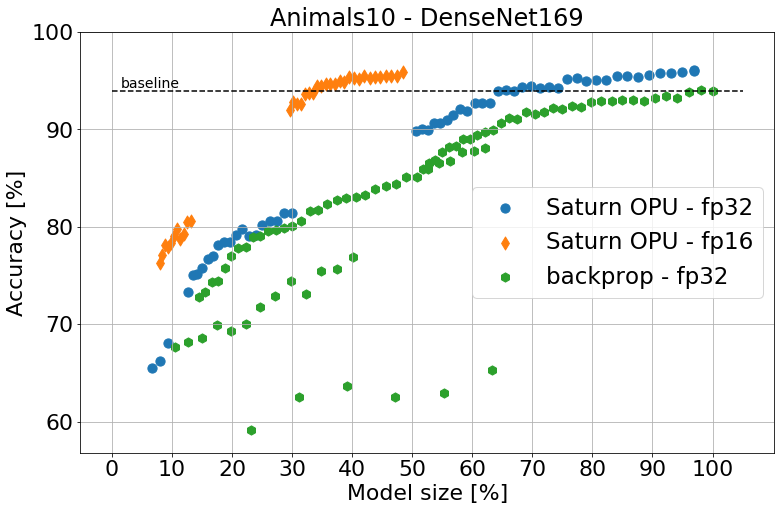

In [7]:
fsize = {'title':24, 'x':22, 'y':22, 'ticks':22, 'legend':23}

full_model_size = backprop["model size-tot"][0]
traces_x = [normalize(train["float32"], full_model_size), normalize(train["float16"], full_model_size), 
            normalize(backprop, full_model_size, bp=True)]
traces_y = [train["float32"]['acc_test'], train["float16"]['acc_test'], backprop["test accuracy"]]

trace_names = ["{} OPU - fp32".format(OPU), "{} OPU - fp16".format(OPU), "backprop - fp32"]
markers = ['o', "d", "h"]
markers_size = 85

plot_labels = {'title':set_title(dataset, model_name), 'x':"Model size [%]", 'y':"Accuracy [%]"}
            
save_path = os.path.join(image_path, "{}_{}_acc.{}".format(model_name, dataset, img_format))


h_lines = [{'line': backprop["test accuracy"][0], 'xmin':0,'xmax':105, "style":"--",
               'label':'baseline', 'x_offset':1.53, 'y_offset':0.3, "fsize":14}]
"""
ellipses = [{'x':100, 'y': flowers_backp_weight["test accuracy"].values[-1],'height':2.5, 'width':2.75, 'fill':False, 'color':'k', "lw":1.5},
           {'x':np.max(normalize(flowers_V_train, full_model_size_flowers)), 'y': flowers_V_train["acc_test"].values[1],'height':2.5, 'width':2.75, 'fill':False, 'color':'k', "lw":1.5}]
"""

y_lower = np.min(traces_y[1]) - np.min(traces_y[1]) % 10
lim = {'x': np.arange(0, 110, 10), 'y': np.arange(y_lower-10, 102, 10)}
    
base_scatter(traces_x, traces_y, trace_names, markers, plot_labels, lim, fsize, h_lines=h_lines,
              markers_size=markers_size, save_path=save_path)

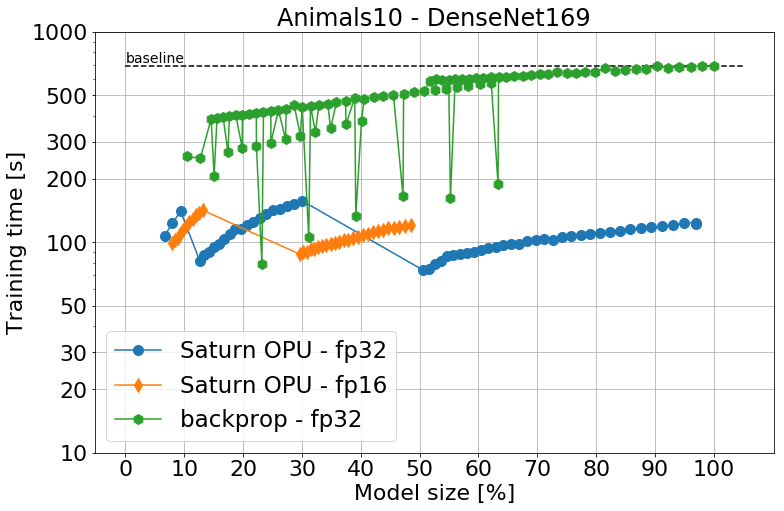

In [8]:
fsize = {'title':24, 'x':22, 'y':22, 'ticks':22, 'legend':23}

traces_x = [normalize(train["float32"], full_model_size), normalize(train["float16"], full_model_size), 
            normalize(backprop, full_model_size, bp=True)]

traces_y = [train["float32"]["total time"], train["float16"]["total time"], 
            backprop["training time"] * (backprop["epoch"] + 1)]


trace_names = ["{} OPU - fp32".format(OPU), "{} OPU - fp16".format(OPU), "backprop - fp32"]

plot_labels = {'title':set_title(dataset, model_name), 'x':"Model size [%]", 'y':"Training time [s]"}

lim = {'x': np.arange(0, 105, 10), 'y': [10, 20, 30, 50, 100, 200, 300, 500, 1000]}
#if np.log10(np.max(backprop["training time"])) > 1.97: # would be 95
#    lim["y"] += [1000, 2000, 3000, 5000,10000, 20000]

markers = ['o', 'd', "h", ""]
linestyle = ["-", "-",  "-", "--"]
colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "magenta"]

h_lines = [{'line':backprop["training time"].values[0]*(backprop["epoch"].values[0] + 1), 'xmin':0,'xmax':105,
            "style":"--", 'label':'baseline', 'x_offset':0, 'y_offset':20, "fsize":14}]

save_path = os.path.join(image_path, "{}_{}_time.{}".format(model_name, dataset, img_format))

base_line(traces_x, traces_y, trace_names, markers, plot_labels, lim, fsize, linestyle=linestyle, colors=colors,
          h_lines=h_lines, save_path=save_path, y_scale="log")

In [34]:
dataset_path ="/home/luca/datasets/animals10/raw-img/"

In [66]:
class_images = []

for directory in os.listdir(dataset_path):
    image = Image.open(glob.glob(os.path.join(dataset_path, directory, "*.jpeg"))[0]).resize((224,224))
    class_images.append(np.array(image))

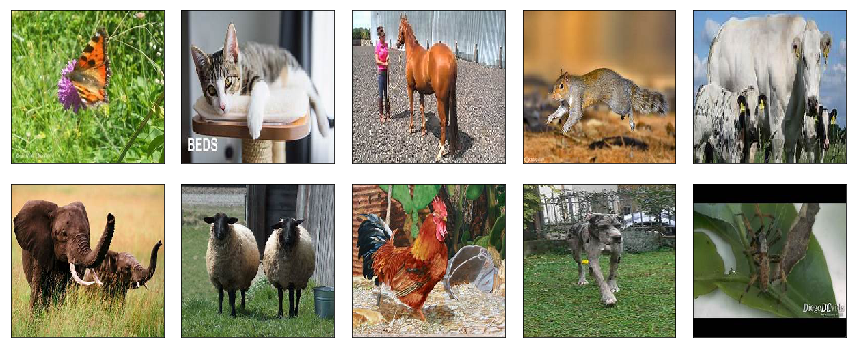

In [113]:
row, col = 2, 5
fig, ax = plt.subplots(row, col, figsize=(12,5))

for idx, image in enumerate(class_images):
    ax[idx//col, idx%col].imshow(image)
    ax[idx//col, idx%col].tick_params(axis="both", left=False, bottom=False, labelbottom=False, labelleft=False)
plt.tight_layout()
plt.savefig(os.path.join(image_path, "dataset_overview.{}".format(img_format)))
plt.show()